In [25]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
import pandas as pd
import optuna
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 41825352

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### Мешок слов плюс линейная модель

Создадим функцию для тестирования наших моделей. Зададим начальный порог и будем обучать, модель на наблюдениях до порога, а тестировать на одном наблюдении после. Двигая порог протестируем нашу модель. И потом сравним с истинными ответами. Качество всех наших моделей будем записывать в табличку.

Обучим логистическую регрессию с l1 регуляризацией, она нам покажет какие слова не влияют на предсказание модели.

In [27]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [28]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    bow, y, LogisticRegression, name='bow l1 only release', plot=False,
    solver='liblinear', penalty='l1', C=c.item(), random_state=RANDOM_STATE
) for c in np.linspace(0.001, 10, 30))

roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=7.931241379310346, penalty='l1', random_state=41825352,
                   solver='liblinear')
ROC-AUC = 0.7765629855637485


Рассмотрим подробнее лучшую модель.

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.53      0.59      0.56        27
         1.0       0.69      0.58      0.63        19

    accuracy                           0.62        69
   macro avg       0.64      0.62      0.63        69
weighted avg       0.63      0.62      0.62        69



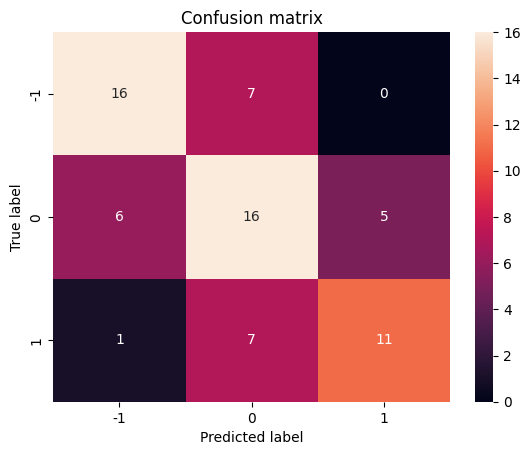

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563


In [29]:
metric, model = calc_metrics(bow, y, LogisticRegression, name='bow l1 only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Мы немного улучшили минимальный бейзлайн. Подберем гиперпараметры для elasticnet с помощью optuna, используя отбор слов при помощи логистической регрессии с L1-регуляризацией. Таким образом мы отбросим дополнительные признаки, которые не важны для этой модели.

In [30]:
def objective(trial, bow):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1),
    }

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            LogisticRegression(C=params["C2"], l1_ratio=params["l1_ratio"], solver='saga',
                                     penalty='elasticnet', max_iter=10000,
                                     random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(bow, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, bow), n_trials=100, show_progress_bar=True)

Best trial: 45. Best value: 0.788909: 100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


Обучим лучшую модель и посмотрим ее оценки качества подробнее.

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.52      0.56      0.54        27
         1.0       0.65      0.58      0.61        19

    accuracy                           0.61        69
   macro avg       0.62      0.61      0.61        69
weighted avg       0.61      0.61      0.61        69



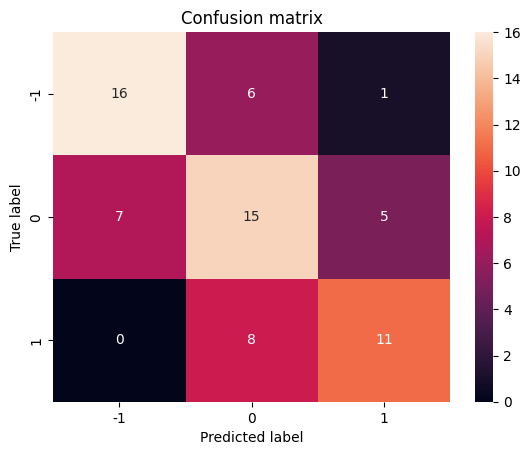

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909


In [31]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(bow, y, pipeline, name='bow elasticnet')
metrics = pd.concat((metrics, metric))
metrics

Качество немного подросло. Попробуем обучить мешок слов не только на пресс-релизах, но и на названиях.

In [32]:
vectorizer_title = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

bow_title = vectorizer_title.transform(X.title)

In [33]:
bow_title_release = np.concatenate((bow.toarray(), bow_title.toarray()), axis=1)

Подберем гиперпараметры для модели обучаемой на названии релиза и самом релизе.

In [34]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, bow_title_release), n_trials=100, show_progress_bar=True)

Best trial: 42. Best value: 0.788019: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Посмотрим на метрики модели и добавим их в таблицу.

              precision    recall  f1-score   support

        -1.0       0.65      0.57      0.60        23
         0.0       0.44      0.56      0.49        27
         1.0       0.60      0.47      0.53        19

    accuracy                           0.54        69
   macro avg       0.56      0.53      0.54        69
weighted avg       0.55      0.54      0.54        69



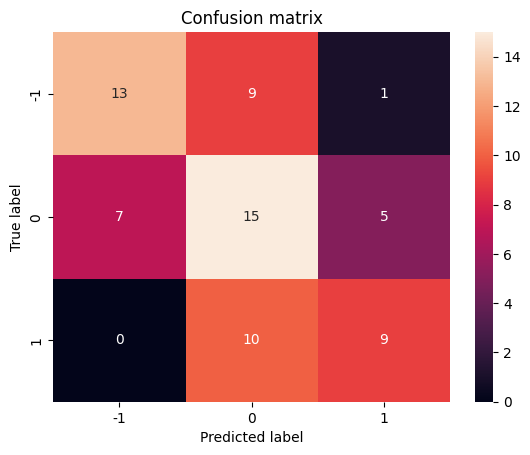

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019


In [35]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    bow_title_release, y, 
    pipeline, 
    name='bow release title'
)

metrics = pd.concat([metrics, metric])
metrics

Добавление мешка слов по названию ухудшило качество модели. Попробуем к мешку слов по текстам релизов, с самыми важными словами добавим количественные признаки.

In [36]:
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

In [37]:
all_data = np.concatenate((bow_title_release, X[num_columns].values), axis=1)

In [38]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, all_data), n_trials=100, show_progress_bar=True)

Best trial: 52. Best value: 0.791621: 100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.52      0.59      0.55        27
         1.0       0.62      0.53      0.57        19

    accuracy                           0.61        69
   macro avg       0.62      0.60      0.61        69
weighted avg       0.62      0.61      0.61        69



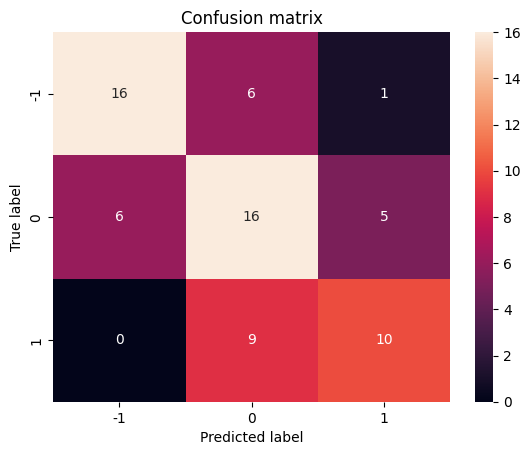

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621


In [39]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    all_data, y, 
    pipeline, 
    name='bow release all num'
    )

metrics = pd.concat([metrics, metric])
metrics

Добавление количественных переменных улучшило нашу модель по метрике ROC-AUC, но не улучшило по accuracy. Попробуем на мешке слов обученный на релизах обучить SVC.

In [40]:
def objective(trial, bow):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    }

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            SVC(C=params["C2"], kernel=params['kernel'], probability=True, random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(bow, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, bow), n_trials=200, show_progress_bar=True)

Best trial: 54. Best value: 0.786507: 100%|██████████| 200/200 [01:03<00:00,  3.16it/s]


              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.55      0.63      0.59        27
         1.0       0.75      0.63      0.69        19

    accuracy                           0.65        69
   macro avg       0.68      0.65      0.66        69
weighted avg       0.66      0.65      0.66        69



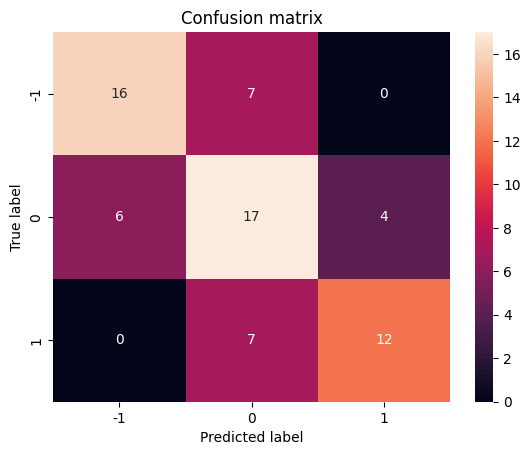

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621
bow svc only release,0.652174,0.661011,0.675220,0.652287,0.780628,0.786126


In [41]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        SVC(C=study.best_params["C2"], kernel=study.best_params['kernel'],
            probability=True, random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    bow, y, 
    pipeline, 
    name='bow svc only release', 
    )

metrics = pd.concat([metrics, metric])
metrics

Метод опорных векторов показал качество по метрике accuracy лучше, чем логистическая регрессия. Сохраним результаты экспериментов.

In [42]:
metrics.to_csv('metrics.csv')